<a href="https://colab.research.google.com/github/Iamsdt/UdacityPyTorch/blob/master/src/notebook/final/Flower4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch

In [2]:
# Load data
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json

!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

!unzip -qq flower_data.zip

print("Data loaded")

Data loaded


In [2]:
# Load train class
!wget -c https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py

import Train

--2018-12-26 08:05:39--  https://raw.githubusercontent.com/Iamsdt/UdacityPyTorch/master/src/notebook/Train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [11]:
import Train

# create train and test loader
data_dir = 'flower_data'

from torchvision import datasets, transforms

# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ceate data loader
train_loader, valid_loader, test_loader = Train.prepare_loader(data_dir,transform_train,transform_valid,test_transforms)

Train size:6552
Valid size:6552
Test size:818


In [17]:
from torchvision import models
# load a pretrained model
model = models.densenet161(pretrained = True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [18]:
print(model.classifier)
#num_ftrs = model.fc.in_features
#print(num_ftrs)
#model.fc = nn.Linear(num_ftrs, 102)
#print(model.fc)
#print(model.fc)

Linear(in_features=2208, out_features=1000, bias=True)


In [23]:
from collections import OrderedDict
from torch import nn

# create a simple classifier
classifier = nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(2208, 512)),
                ('relu', nn.ReLU()),
                ('dropout',nn.Dropout(p=0.2)),
                ('fc2', nn.Linear(512, 400)),
                ('relu', nn.ReLU()),
                ('dropout',nn.Dropout(p=0.2)),
                ('fc3', nn.Linear(400, 102)),
                ('output', nn.LogSoftmax(dim=1))
                ]))

# replace the classifer
model.classifier = classifier
# check the classifier
print(model.classifier)

Sequential(
  (fc1): Linear(in_features=2208, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (fc2): Linear(in_features=512, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=102, bias=True)
  (output): LogSoftmax()
)


In [0]:
import torch
from torch import optim
from torch.optim import lr_scheduler
# set cretrion and optimizer
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

optimizer = optim.Adadelta(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)

#move tensor to default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [0]:
# Freeze the parameter
#model = Train.freeze_parameters(model)
for _, param in model.named_parameters():
  param.requires_grad = False

In [0]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0

In [0]:
# Train model
epochs = 10
model, train_loss,valid_loss = Train.train_model(
    model,train_loader,valid_loader, epochs, optimizer,scheduler, criterion)

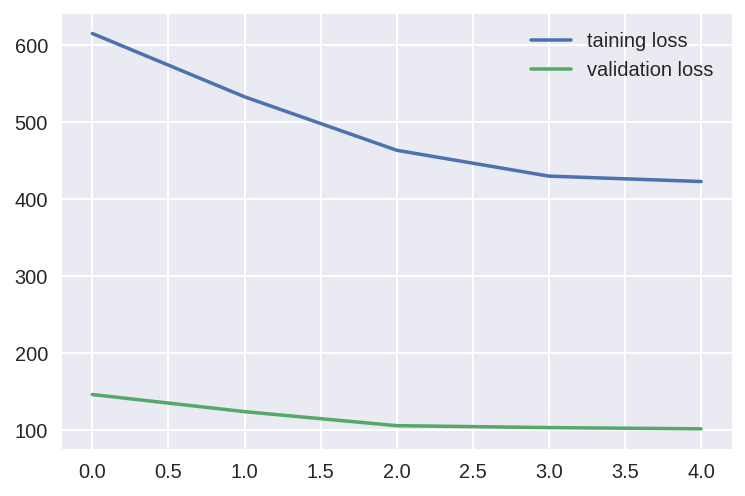

In [50]:
#Check for overfitting

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_loss, label = "taining loss")
plt.plot(valid_loss, label = "validation loss")
plt.legend(frameon = False)

In [0]:
# Unfreeze the parameter
#model = Train.unfreeze(model)
for _, param in model.named_parameters():
  param.requires_grad = True

In [14]:
# Test accuracy top 10 classs
Train.calculate_top_accuracy(model, test_loader, criterion)

Test Loss: 0.196509

Test Accuracy of     0:  0% ( 0/ 2)
Test Accuracy of     1:  0% ( 0/ 1)
Test Accuracy of     2:  0% ( 0/ 3)
Test Accuracy of     3:  0% ( 0/ 4)
Test Accuracy of     4:  0% ( 0/ 1)
Test Accuracy of     5:  0% ( 0/ 6)
Test Accuracy of     6:  0% ( 0/ 3)
Test Accuracy of     7:  0% ( 0/ 4)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9:  0% ( 0/ 4)

Test Accuracy (Overall):  7% (30/410)


In [0]:
# Test total accuracy
Train.calc_accuracy(model,testset_path="flower_data/valid")

In [0]:
# Test with google data set
Train.calc_accuracy(model,use_google_testset=True)

In [0]:
cat_to_name = Train.get_cat_name()

In [0]:
# visualize data